In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne
import math

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *
import glob
import os


import seaborn as sns
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Wavelet for multiple subjects listen and motor

In [2]:
ch_to_visualize = ['Cz']

wavelet_dir_l = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_listen__n05to05_30Hz_all_ave'
wavelet_dir_m = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_motor__n05to05_30Hz_all_ave'
wavelet_dir_t = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_training__n05to05_30Hz_all_ave'

subjects_to_process = find_existing_subjects(wavelet_dir_t)
#subjects_to_process = ['13', '18', '12', '02']
print('processing subjects', subjects_to_process)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir_t,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

processing subjects ['05', '06', '07', '08', '09', '10', '11', '12']


##### Initialize directories

In [32]:

power_df_m = power_over_subs(subjects_to_process, wavelet_dir_m, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_l = power_over_subs(subjects_to_process, wavelet_dir_l, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)
power_df_t = power_over_subs(subjects_to_process, wavelet_dir_t, freqs_to_sum='all', already_ave=True, ch_to_process = ch_to_visualize)


power_df_m_pre = power_df_m.query("period == 'pre'")
power_df_l_pre = power_df_l.query("period == 'pre'")
power_df_m_post = power_df_m.query("period == 'post'")
power_df_l_post = power_df_l.query("period == 'post'")

skipping sub 01
skipping sub 03
skipping sub 04
skipping sub 13
skipping sub 14
skipping sub 15
skipping sub 16
skipping sub 18
skipping sub 19
skipping sub 20
skipping sub 01
skipping sub 03
skipping sub 04
skipping sub 13
skipping sub 14
skipping sub 15
skipping sub 16
skipping sub 18
skipping sub 19
skipping sub 20
skipping sub record
skipping sub 01
skipping sub 02
skipping sub 03
skipping sub 04
skipping sub 13
skipping sub 14
skipping sub 15
skipping sub 16
skipping sub 17
skipping sub 18
skipping sub 19
skipping sub 20
skipping sub 21
skipping sub 01
skipping sub 02
skipping sub 03
skipping sub 04
skipping sub 13
skipping sub 14
skipping sub 15
skipping sub 16
skipping sub 17
skipping sub 18
skipping sub 19
skipping sub 20
skipping sub 21
skipping sub record
skipping sub record


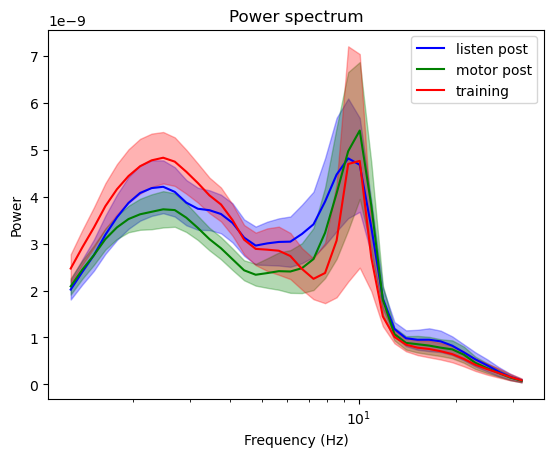

In [33]:
plot_power_freqs(freqs, power_df_l_post, color = 'blue', label = 'listen post')
plot_power_freqs(freqs, power_df_m_post, color = 'green', label = 'motor post')
plot_power_freqs(freqs, power_df_t, color = 'red', label = 'training')
plt.title(f'Power spectrum')
plt.legend()


Difference in power

In [59]:
power_diff = power_df_t['power']- power_df_m_post['power']
power_diff = np.vstack(power_diff)

Text(0.5, 1.0, ' difference task vs training')

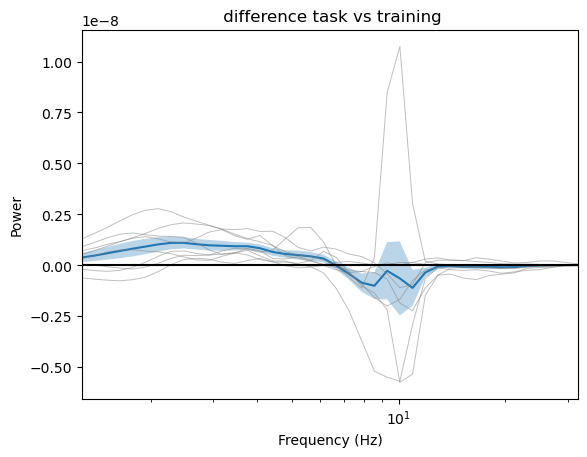

In [60]:
plot_power_freqs(freqs,power_diff)
for sub in range(power_diff.shape[0]):
    plt.plot(freqs, power_diff[sub, :], color = 'grey', alpha = 0.5, linewidth = 0.7)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])
plt.title(f' difference task vs training')

Stats

In [61]:
freq_to_test_low = 5
freq_to_test_high = 10

lim1 = index_custom([freq_to_test_low],freqs)[0]
lim2 = index_custom([freq_to_test_high], freqs)[0]
test_stats, p_values = t_within_points(power_diff, lim1=lim1, lim2=lim2)

testing gaussianity over 8 points
Distribution is not normal. p =  0.022590637230360117
using wilcoxon test
fdr correction over 9 points


testing gaussianity over 8 points
Distribution is not normal. p =  0.022590637230360117
using wilcoxon test
fdr correction over 9 points


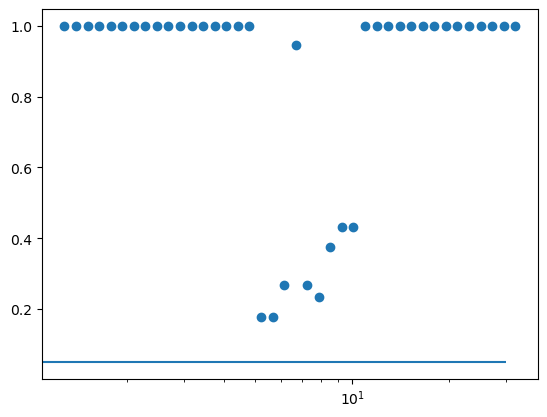

In [62]:
test_stats, p_values = t_within_points(power_diff, lim1=lim1, lim2=lim2)
plt.scatter(freqs, p_values)
plt.hlines(0.05, 0, 30)
plt.xscale('log')

Text(0.5, 1.0, 'Training - motor post (8 subjects)')

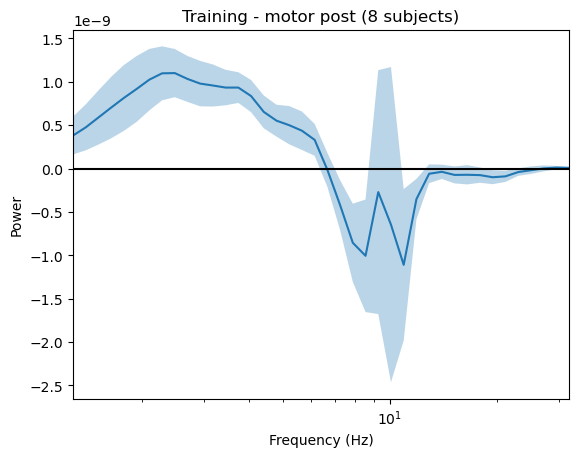

In [67]:
sig_idx = [i for i, p in enumerate(p_values) if p < 0.05]

plot_power_freqs(freqs, power_diff)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])

sig_y_pos = np.max(power_diff)
plt.scatter(freqs[sig_idx], [sig_y_pos]*len(sig_idx), marker = "*", color = 'grey')
plt.title(f'Training - motor post (8 subjects)')

bootstrap/jackknife

In [64]:
from sklearn.utils import resample

def jackknife_1samp(data_point, test):
    """
    estimate distribution of p values (also test statistics)
    data_freq: data of shape n_subs, already indexed for the freq or timepoint of interest
    test: which test to do. Usually wilcoxon

    ---
    returns:
    p_vals: distribution of p values
    ---
    """
    n_subs = data_point.shape[0]

    t_stat_jk = []
    p_val_jk = []
    
    for sub in range(n_subs):
        data_resampled = np.delete(data_point, sub)
        res = test(data_resampled)
        p_val_jk.append(res.pvalue)
        t_stat_jk.append(res.statistic)

    return t_stat_jk, p_val_jk
        
    



In [65]:

p_distr_all = []
for freq in range(power_diff.shape[1]):
    _, p_vals = jackknife_1samp(power_diff[:, freq], test= wilcoxon)
    p_distr_all.append(p_vals)
p_distr_all = np.array(p_distr_all)

Text(0.5, 0, 'freqs')

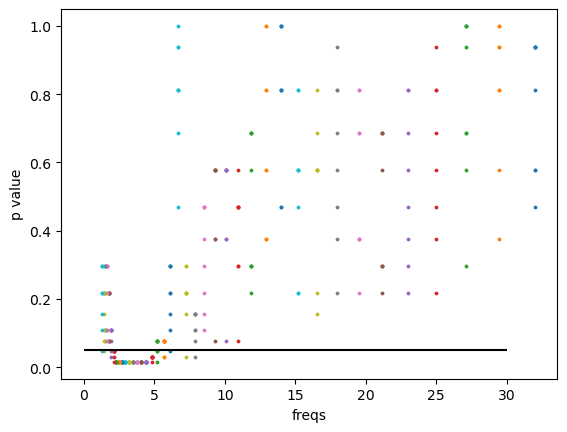

In [66]:
for i, freq in enumerate(freqs): 
    plt.scatter([freq]*p_distr_all.shape[1], p_distr_all[i], s = 3)

plt.hlines(0.05, 0,30, color = 'black')
plt.ylabel('p value')
plt.xlabel('freqs')